<a href="https://colab.research.google.com/github/s-ravi18/Model_Architectures_From_Scratch/blob/main/LLMs/Hands_on_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coding the RNN from scratch;

In [ ]:
## Coding the RNN from scratch;


import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch



In [ ]:

# Step 0.
## initialise the hidden state (h0) - weights from a normal curve;
## initialise the weight matrix for hidden state (Wh) - weights from a normal curve;
## initialise the weight matrix for input vector (Wx) - weights from a normal curve;

# Step 1.

## Pick up the first token of the sequence;

## calcuate the output after consuming first token
## calculate the new hidden state

## ht = F(Wh * ht-1 + Wx * Xt)

# Step 2.

## Pick up the next token of the sequence

## calcuate the output after consuming first token
## calculate the new hidden state

# Step 3. Repeat Step 2 n times


## The final hidden state after processing the last token of the input sequence, after multiple iterations would be the encoded vector which is passed to the
## decoder







In [ ]:
## Coding LSTMs from scratch;


import numpy as np

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # weight matrices
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size) * 0.1

        # biases
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))

    def forward(self, x_t, h_prev, C_prev):
        # concatenate h(t-1) and x(t)
        concat = np.vstack((h_prev, x_t))

        # gates
        f_t = sigmoid(self.Wf @ concat + self.bf)
        i_t = sigmoid(self.Wi @ concat + self.bi)
        o_t = sigmoid(self.Wo @ concat + self.bo)
        C_hat = np.tanh(self.Wc @ concat + self.bc)

        # new cell and hidden state
        C_t = f_t * C_prev + i_t * C_hat
        h_t = o_t * np.tanh(C_t)

        return h_t, C_t

# ------------ Encoder --------------------------

class Encoder:
    def __init__(self, input_size, hidden_size):
        self.lstm = LSTMCell(input_size, hidden_size)

    def encode(self, X):
        h = np.zeros((self.lstm.hidden_size, 1))
        C = np.zeros((self.lstm.hidden_size, 1))

        for x_t in X:   ### Sequential scanning of the input and updating cell and hidden state.
            x_t = x_t.reshape(-1, 1)
            h, C = self.lstm.forward(x_t, h, C)

        return h, C  # context vector

# ------------ Decoder --------------------------

class Decoder:
    def __init__(self, input_size, hidden_size, output_size):
        self.lstm = LSTMCell(input_size, hidden_size)
        self.Wy = np.random.randn(output_size, hidden_size) * 0.1
        self.by = np.zeros((output_size, 1))

    def decode(self, context_h, context_C, max_len, start_vector, vocab):
        h, C = context_h, context_C
        x_t = start_vector.reshape(-1, 1)

        outputs = []

        for _ in range(max_len):
            h, C = self.lstm.forward(x_t, h, C)
            y_pred = softmax(self.Wy @ h + self.by)
            token = np.argmax(y_pred)
            outputs.append(token)

            # next input = embedding of predicted token
            x_t = vocab[token].reshape(-1, 1)

        return outputs


In [ ]:
# ------------ Tiny Translation Example ---------

# Fake embeddings for demonstration
embed = {
    "i": np.array([1,0,0], dtype=float),
    "love": np.array([0,1,0], dtype=float),
    "apples": np.array([0,0,1], dtype=float),

    # French tokens
    "<SOS>": np.array([1,1,1], dtype=float),
    "j'": np.array([1,0,1], dtype=float),
    "aime": np.array([0,1,1], dtype=float),
    "les": np.array([1,1,0], dtype=float),
    "pommes": np.array([0,1,0], dtype=float)
}

# vocab index for decoding
vocab_list = ["j'", "aime", "les", "pommes"]
vocab_vectors = [embed[v] for v in vocab_list]

# Encoder input (English sentence)
X = [
    embed["i"],
    embed["love"],
    embed["apples"]
]

In [ ]:
encoder = Encoder(input_size=3, hidden_size=4)
decoder = Decoder(input_size=3, hidden_size=4, output_size=len(vocab_list))

context_h, context_C = encoder.encode(X)

# Decode to max length 4
output_ids = decoder.decode(
    context_h=context_h,
    context_C=context_C,
    max_len=4,
    start_vector=embed["<SOS>"],
    vocab=vocab_vectors
)

translated_tokens = [vocab_list[i] for i in output_ids]
print("Predicted translation:", translated_tokens)


Predicted translation: ["j'", 'pommes', "j'", 'pommes']


## Coding the GPT-2 from scratch;

In [2]:
## Coding the GPT-2 from scratch;

## ENCODER

## Tokenisation
## Text Embedding
## Position Embedding - For parallelism (could be learnt parameters)

## Multi Dimensions - 32/64/...
## Self Attention Mechanism - each k, q, v is of dimension (max_len, d_head) ## unsqueeze
## Concatenating the outputs of all the heads

## MLP - GELU as the activation function

## The K, Q are reused in the decoder;

## DECODER;

## Self-Attention mechanism - Masked Inferencing - incorporates the lower triangle matrix while attention calculation
## MLP
## Final output - probabilityfor each word in the vocab
## Top K, Greedy, etc... ways of token sampling/selection




In [3]:
# BUILDING THE ENCODER BLOCK;

import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = d_k ** 0.5

    def forward(self, Q, K, V, mask=None):
        # Q, K, V: (batch, heads, seq_len, d_k)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        weights = F.softmax(scores, dim=-1)

        output = torch.matmul(weights, V)
        return output, weights


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0)/d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len].to(x.device)


# self.pos_emb = nn.Embedding(max_len, d_model)
# pos_ids = torch.arange(0, seq_len).unsqueeze(0).to(x.device)
# x = x + self.pos_emb(pos_ids)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear layers to project input → Q, K, V
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)

        # Output linear projection
        self.W_O = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # Project to Q, K, V
        Q = self.W_Q(x)  # (batch, seq, d_model)
        K = self.W_K(x)
        V = self.W_V(x)

        # Reshape for multi-heads
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        weights = F.softmax(scores, dim=-1)

        # Weighted sum
        attention = torch.matmul(weights, V)  # (batch, heads, seq, d_k)

        # Concatenate heads
        attention = attention.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        # Final projection
        out = self.W_O(attention)

        return out, weights



# x = torch.rand(2, 5, 512)
# mha = MultiHeadAttention(d_model=512, num_heads=8)
# out, weights = mha(x)
# print(out.shape)      # expected (2, 5, 512)
# print(weights.shape)  # expected (2, 8, 5, 5)


class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, d_model),
        )

    def forward(self, x):
        return self.net(x)



class EncoderBlock(nn.Module):
    def __init__(self, d_model=512, num_heads=8, hidden_dim=2048):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, num_heads)

        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, hidden_dim)

    def forward(self, x, mask=None):
        # Attention block
        attn_out, _ = self.mha(self.ln1(x), mask)
        x = x + attn_out  # residual

        # FFN block
        ffn_out = self.ffn(self.ln2(x))
        x = x + ffn_out  # residual

        return x

In [4]:
# DECODER BLOCK;

class DecoderBlock(nn.Module):
    def __init__(self, d_model=512, num_heads=8, hidden_dim=2048):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(d_model, num_heads)

        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, hidden_dim)

    def forward(self, x, causal_mask):
        # Self-attention with causal mask
        attn_out, _ = self.self_attn(self.ln1(x), mask=causal_mask)
        x = x + attn_out

        # Feed-forward
        ffn_out = self.ffn(self.ln2(x))
        x = x + ffn_out

        return x


def causal_mask(seq_len):
    mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0)
    return mask  # shape: (1,1,seq,seq)


In [5]:
class MiniEncoder(nn.Module):
    def __init__(self, num_layers=2):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock() for _ in range(num_layers)])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


## Application 1. Training an Encoder only architecure;

- Used for Analysing context/patterns (Understanding)

- Example: Sentence Classification/Similar Embedding creation, etc...

In [ ]:
# Input → Token Embedding + Positional Encoding
#       → N EncoderBlocks
#       → CLS output
#       → Linear Layer → Softmax

In [6]:
class MiniBERT(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, n_layers=2, hidden_dim=256, max_len=128, num_labels=2):
        super().__init__()

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([
            EncoderBlock(d_model, n_heads, hidden_dim)
            for _ in range(n_layers)
        ])


# class EncoderBlock(nn.Module):
#     def __init__(self, d_model=512, num_heads=8, hidden_dim=2048):
#         super().__init__()

#         self.ln1 = nn.LayerNorm(d_model)
#         self.mha = MultiHeadAttention(d_model, num_heads)

#         self.ln2 = nn.LayerNorm(d_model)
#         self.ffn = FeedForward(d_model, hidden_dim)

#     def forward(self, x, mask=None):
#         # Attention block
#         attn_out, _ = self.mha(self.ln1(x), mask)
#         x = x + attn_out  # residual

#         # FFN block
#         ffn_out = self.ffn(self.ln2(x))
#         x = x + ffn_out  # residual

#         return x


        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids):  ## (1, 5)
        B, T = input_ids.shape
        pos = torch.arange(0, T).unsqueeze(0).to(input_ids.device)  ## (1, 5)

        x = self.token_emb(input_ids) + self.pos_emb(pos)

        for layer in self.layers:
            x = layer(x)

        x = self.ln_f(x)

        cls_token = x[:, 0, :]  # use first token representation

        logits = self.classifier(cls_token)
        return logits

## Sample data;
sentences = [
    "I love this movie",
    "This film is terrible",
    "Amazing acting!",
    "Worst story ever"
]

labels = [1, 0, 1, 0]   # 1 = positive, 0 = negative



word2id = {"<pad>":0, "<cls>":1}

## Tokenising
for s in sentences:
    for w in s.lower().split(" "):
        if w not in word2id:
            word2id[w] = len(word2id)

def encode(sentence):
    tokens = [word2id[w] for w in sentence.lower().split()]
    return torch.tensor([1] + tokens)   # prepend CLS


In [ ]:
model = MiniBERT(vocab_size=len(word2id))
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  ## for learning the parameters...
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1000):
    total_loss = 0

    for s, y in zip(sentences, labels):
        x = encode(s).unsqueeze(0)  ### (5, ) --> (1, 5)
        y = torch.tensor([y])

        logits = model(x)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 200 == 0:
        print("Epoch:", epoch, "Loss:", total_loss)


## Visualising contextualised vectors;

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load a contextual embedding model (MiniLM or BERT)
model_name = "bert-base-uncased"   # you can change to "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Sentences containing the word "bank" in two meanings
sent1 = "He deposited money in the bank."
sent2 = "They sat on the bank of the river."


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:

def get_token_embedding(sentence, target_word):
    tokens = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)
    outputs = model(**tokens)
    hidden_states = outputs.last_hidden_state  # shape: [1, sequence_length, hidden_size]

    # Convert token IDs to tokens
    token_words = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])

    # Find indices of the target word
    indices = [i for i, tok in enumerate(token_words) if target_word in tok]

    # Average embeddings if word is split into subword tokens
    embedding = hidden_states[0, indices, :].mean(dim=0).detach().numpy()

    return embedding, token_words, indices

# Get embeddings of "bank" in both contexts
emb1, tok1, idx1 = get_token_embedding(sent1, "bank")
emb2, tok2, idx2 = get_token_embedding(sent2, "bank")


In [ ]:
print("Tokenized Sentence 1:", tok1)
print("Position of 'bank':", idx1)
print("Tokenized Sentence 2:", tok2)
print("Position of 'bank':", idx2)

# Cosine similarity
sim = cosine_similarity([emb1], [emb2])[0][0]
print("\nCosine Similarity between 'bank' meanings:", sim)


Tokenized Sentence 1: ['[CLS]', 'he', 'deposited', 'money', 'in', 'the', 'bank', '.', '[SEP]']
Position of 'bank': [6]
Tokenized Sentence 2: ['[CLS]', 'they', 'sat', 'on', 'the', 'bank', 'of', 'the', 'river', '.', '[SEP]']
Position of 'bank': [5]

Cosine Similarity between 'bank' meanings: 0.5110515


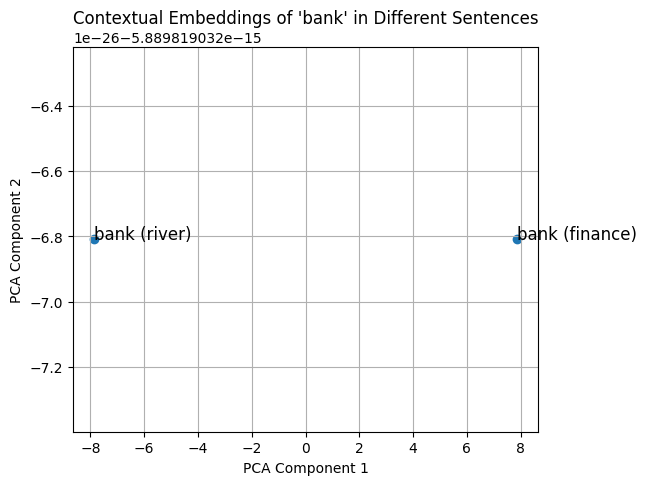

In [ ]:
# PCA for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform([emb1, emb2])

plt.figure(figsize=(6, 5))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.text(embeddings_2d[0, 0], embeddings_2d[0, 1], "bank (finance)", fontsize=12)
plt.text(embeddings_2d[1, 0], embeddings_2d[1, 1], "bank (river)", fontsize=12)
plt.title("Contextual Embeddings of 'bank' in Different Sentences")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()